In [1]:
import sys
!{sys.executable} -m pip install python-dotenv

In [2]:
from dotenv import dotenv_values

config = dotenv_values("../.env")

In [20]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
import cartopy.crs as ccrs
import hvplot.xarray
import hvplot.pandas
import hvplot.dask

import geopandas as gpd

In [4]:
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()
cluster = gateway.new_cluster()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [5]:
cluster.scale(4)
client = Client(cluster)
cluster

In [7]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# filter out France especially because of regions in south america
gdf = gdf[(gdf["continent"] == "Europe") & (gdf["name"] != "Russia") & (gdf["name"] != "France")]

<AxesSubplot:>

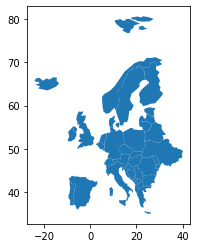

In [8]:
gdf.plot()

In [9]:
west, south, east, north = gdf.total_bounds
west, south, east, north

(-24.326184047939336, 34.91998769788964, 40.080789015469406, 80.65714427359343)

In [10]:
def fix_accum_var_dims(ds, var):
    # Some varibles like precip have extra time bounds varibles, we drop them here to allow merging with other variables
    
    # Select variable of interest (drops dims that are not linked to current variable)
    ds = ds[[var]]  

    if var in ['air_temperature_at_2_metres',
               'dew_point_temperature_at_2_metres',
               'air_pressure_at_mean_sea_level',
               'northward_wind_at_10_metres',
               'eastward_wind_at_10_metres']:
        
        ds = ds.rename({'time0':'valid_time_end_utc'})
        
    elif var in ['precipitation_amount_1hour_Accumulation',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation']:
        
        ds = ds.rename({'time1':'valid_time_end_utc'})
        
    else:
        print("Warning, Haven't seen {var} varible yet! Time renaming might not work.".format(var=var))
        
    return ds

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})
    return s3fs.S3Map(path, s3=fs)


def open_era5_range(start_year, end_year, variables):
    ''' Opens ERA5 monthly Zarr files in S3, given a start and end year (all months loaded) and a list of variables'''
    
    
    file_pattern = 'era5-pds/zarr/{year}/{month}/data/{var}.zarr/'
    
    years = list(np.arange(start_year, end_year+1, 1))
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    
    l = []
    for var in variables:
        print(var)
        
        
        #files_mapper = [s3open(file_pattern.format(year=year, month=month, var=var)) for year in years for month in months]
        
        # Get files
        files_mapper = []
        for year in years:
            for month in months:
                # if year == 2021 and month == "12":
                #     continue
                # else:
                files_mapper.append(s3open(file_pattern.format(year=year, month=month, var=var)))
        
        # Look up correct time dimension by variable name
        if var in ['precipitation_amount_1hour_Accumulation']:
            concat_dim='time1'
        else:
            concat_dim='time0'
            
        # Lazy load
        ds = xr.open_mfdataset(files_mapper, engine='zarr', 
                               concat_dim=concat_dim, combine='nested', 
                               coords='minimal', compat='override', parallel=True)
        
        # Fix dimension names
        ds = fix_accum_var_dims(ds, var)
        l.append(ds)
        
    ds_out = xr.merge(l)
    
    return ds_out

In [11]:
%%time
ds = open_era5_range(2011, 2021, ["air_temperature_at_2_metres", "northward_wind_at_10_metres", "eastward_wind_at_10_metres"])

air_temperature_at_2_metres
northward_wind_at_10_metres
eastward_wind_at_10_metres
CPU times: user 3.56 s, sys: 525 ms, total: 4.09 s
Wall time: 1min 45s


In [12]:
ds

<xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 96432, lat: 721, lon: 1440)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    northward_wind_at_10_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    eastward_wind_at_10_metres   (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [25]:
 ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
 ds = ds.sortby(ds.lon)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

In [27]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 1201.44



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 96432, lat: 721, lon: 1440)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 -180.0 -179.8 ... 179.5 179.8
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 150, 30), meta=np.ndarray>
    northward_wind_at_10_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 150, 30), meta=np.ndarray>
    eastward_wind_at_10_metres   (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 150, 30), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts>

In [28]:
ds_europe = ds.sel({"lon": slice(west, east), "lat": slice(north, south)})
print('ds size in GB {:0.2f}\n'.format(ds_europe.nbytes / 1e9))
ds_europe.info

ds size in GB 54.64



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 96432, lat: 183, lon: 258)
Coordinates:
  * lat                          (lat) float32 80.5 80.25 80.0 ... 35.25 35.0
  * lon                          (lon) float32 -24.25 -24.0 ... 39.75 40.0
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 112, 7), meta=np.ndarray>
    northward_wind_at_10_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 112, 7), meta=np.ndarray>
    eastward_wind_at_10_metres   (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 112, 7), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts>

In [29]:
ds_europe["air_temperature_at_2_metres"] = (ds_europe.air_temperature_at_2_metres - 273.15)
ds_europe.air_temperature_at_2_metres.attrs["units"] = "C"

In [31]:
ds_europe["air_temperature_at_2_metres"].sel({"valid_time_end_utc": "2019-01-01T00:00:00.000000000"}).hvplot.quadmesh(coastline=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py

:Overlay
   .QuadMesh.I  :QuadMesh   [lon,lat]   (air_temperature_at_2_metres)
   .Coastline.I :Feature   [Longitude,Latitude]

In [32]:
sfs = s3fs.S3FileSystem(
    anon=False,
    key="gregor",
    secret=config["fue_s3_key"],
    client_kwargs={
        "endpoint_url": "http://s3.fuecluster.hakom.at:9000",
    }
)
mapper = sfs.get_mapper("/energy-market-visual-exploration/era5_hourly_europe_2011_2021.zarr")

In [33]:
# delete chunk encoding
for var in ds_europe:
    if "chunks" in ds_europe[var].encoding.keys():
        del ds_europe[var].encoding["chunks"]

In [38]:
ds_europe.chunk({"valid_time_end_utc": 24 * 30, "lat": 20, "lon": 20}).to_zarr(mapper, mode="w")

In [39]:
ds_reloaded = xr.open_zarr(mapper)
ds_reloaded

<xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 96432, lat: 183, lon: 258)
Coordinates:
  * lat                          (lat) float32 80.5 80.25 80.0 ... 35.25 35.0
  * lon                          (lon) float32 -24.25 -24.0 ... 39.75 40.0
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    eastward_wind_at_10_metres   (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    northward_wind_at_10_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [40]:
print('ds size in GB {:0.2f}\n'.format(ds_reloaded.nbytes / 1e9))
ds_reloaded.info

ds size in GB 54.64



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 96432, lat: 183, lon: 258)
Coordinates:
  * lat                          (lat) float32 80.5 80.25 80.0 ... 35.25 35.0
  * lon                          (lon) float32 -24.25 -24.0 ... 39.75 40.0
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    eastward_wind_at_10_metres   (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    northward_wind_at_10_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts>

In [41]:
client.close()
cluster.close()